# Шаг 1

 * Для начала, давайте посмотрим на распределение посещений сайта по дням. 
 * Постройте график с распределением количества посещений от ботов и обычных пользователей сайта Яндекс.Метрика с 2021-07-14 и 2021-07-16.
 * Данные для построения графика хранятся здесь: https://api-metrika.yandex.net/stat/v1/data?



In [1]:
import pandas as pd
import requests
import seaborn as sns
from urllib.parse import urlencode
import matplotlib.pyplot as plt
%matplotlib inline
import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials
import json
import vk_api
import random
from io import BytesIO

In [2]:
url = 'https://api-metrika.yandex.net/stat/v1/data?'
dates = ['2021-07-14','2021-07-15','2021-07-16']

df = pd.DataFrame()

for date in dates:   
    
    # Выставим необходимые параметры 
    params = {
        'metrics': 'ym:s:visits', 
        'dimensions': ['ym:s:date', 'ym:s:isRobot'],
        'filters': f"ym:s:date=='{date}'",
        'id': 44147844
    }
    
    # Преобразуем в ссылку
    visits = urlencode(params, doseq=True)  
    
    # Получим полный адрес
    visits_url = url + visits 
    
    # Сделаем запрос к API Яндекс.Метрика
    response = requests.get(visits_url) 
    
    # Перевем полученный респонс в JSON формат
    json_data = response.json()
    
    # Распарсим данные с Яндекс.Метрика
    for record in json_data['data']:
        
        temp_data = record['dimensions']

        visits = record['metrics'][0]
        date = temp_data[0]['name']
        robot_type = temp_data[1]['name']
        
        # Создадим строку и добавим в датафрейм
        row = [[date, robot_type, visits]]
        df = df.append(row)
        

In [3]:
# Изменим названия колонок
df.columns = ['date', 'type', 'visits']

In [4]:
df

,date,type,visits
0,2021-07-14,People,334.0
0,2021-07-14,Robots,177.0
0,2021-07-15,People,402.0
0,2021-07-15,Robots,158.0
0,2021-07-16,People,294.0
0,2021-07-16,Robots,132.0


<AxesSubplot:xlabel='date', ylabel='visits'>

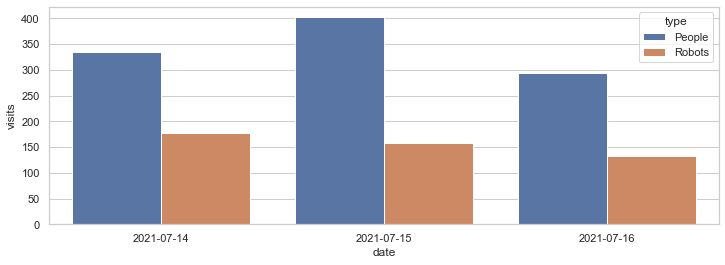

In [5]:
# Построим график с распределением количества посещений от ботов и обычных пользователей
sns.set(style = 'whitegrid',
        rc={'figure.figsize':(12,4)})

sns.barplot(x='date',
            y='visits',
            hue='type',
            data= df)

# Шаг 2

 * Определите процент посещений сайта Яндекс.Метрики с бразузера Google  за 2021-07-13
 * Ответ округлите до целого.


In [6]:
# Можем переиспользовать полученный ранее код
df2 = pd.DataFrame()

# Добавим к параметрам тип бразуера
params = {
    'metrics': 'ym:s:visits', 
    'dimensions': ['ym:s:date', 'ym:s:isRobot', 'ym:s:browser'],
    'filters': f"ym:s:date=='2021-07-13'",
    'id': 44147844
}
    
visits = urlencode(params, doseq=True)     
visits_url = url + visits    
response = requests.get(visits_url)     
json_data = response.json()
    
for record in json_data['data']:    
    temp_data = record['dimensions']
    visits = record['metrics'][0]
    date = temp_data[0]['name']
    robot_type = temp_data[1]['name']
    # получим данные по тип браузера
    user_type = temp_data[2]['name']
    
    # добавим его к датафрейму
    row = [[date, robot_type, user_type, visits]]
    df2 = df2.append(row)

In [7]:
# Переименуем колонки нового датафрейма
df2.columns = ['date', 'robot_type', 'user_type', 'visits']

In [8]:
df.head()

,date,type,visits
0,2021-07-14,People,334.0
0,2021-07-14,Robots,177.0
0,2021-07-15,People,402.0
0,2021-07-15,Robots,158.0
0,2021-07-16,People,294.0


In [9]:
# Сделаем группировку по типу браузера
visits_vs_browser = df2.groupby('user_type') \
                       .agg({'visits': 'sum'})

In [10]:
# Получим процент посещений сайта Яндекс.Метрики с бразузера Google за 2021-07-14
# Ответ
visits_vs_browser.loc['Google Chrome'] \
    .div(visits_vs_browser.sum()) \
    .mul(100) \
    .round()

visits    62.0
dtype: float64

# Шаг 3

 * Давайте выясним, с какого браузера приходит БОЛЬШЕ всего ботов. 
 * Посмотрите на данные и определите, у какого браузера самая БОЛЬШАЯ доля посещений сайта ботами от общего числа посещений?
 * В качестве ответа укажите название браузера.


In [11]:
# Уберем индекс
visits_vs_browser = visits_vs_browser.reset_index()

In [12]:
# Соединим два датафрейма
full_df = df2.merge(visits_vs_browser,
                    on = 'user_type',
                    suffixes = ('_type','_all'))

In [13]:
# Создадим столбец с отношением количества посещений к общему количеству посещений по типу браузера
full_df['ratio'] = full_df.visits_type / full_df.visits_all
full_df.head()

,date,robot_type,user_type,visits_type,visits_all,ratio
0,2021-07-13,People,Google Chrome,211.0,347.0,0.608069
1,2021-07-13,Robots,Google Chrome,136.0,347.0,0.391931
2,2021-07-13,People,Yandex Browser,43.0,50.0,0.860000
3,2021-07-13,Robots,Yandex Browser,7.0,50.0,0.140000
4,2021-07-13,People,Chrome Mobile,39.0,39.0,1.000000


In [14]:
# Найдем  браузера с самой большой долей посещений сайта ботами от общего числа посещений
# Ответ
full_df.query('robot_type == "Robots"') \
    .nlargest(1, columns ='ratio') \
    .user_type \
    .iloc[0]

'Firefox'

# Шаг 4 

 * Съагрегируйте данные по дню, типу пользователя, браузеру, создайте колонку с метрикой доли заходов на сайт для каждого из этих разрезов.
 * В ответе укажите процент открытий сайта настоящими пользователями Safari (не ботами) с точностью до 1 знака после точки.




In [15]:
# Прежде, чем делать группировку, проверим, не являются ли строки по данным колонкам итак уникальными
df2.duplicated(['date', 'robot_type' , 'user_type']).sum()  

0

In [16]:
# Таким образом, в группировке нет смысла, поэтому создадим колонку с метрикой доли заходов на сайт для каждого из этих разрезов
df2['share_visits'] =  df2.visits / df2.visits.sum() * 100

In [17]:
# Процент открытий сайта настоящими пользователями Safari (не ботами) 
# Ответ
df2.query('robot_type=="People" and user_type=="Safari"') \
    .share_visits \
    .iloc[0] \
    .round(1)

2.8

# Шаг 5

 * При помощи библиотеки gspread отправьте данные из предыдущего шага в Google SpreadSheet. 
 * Далее отправьте ссылку на получившийся файл в Google SpreadSheet (не забудьте открыть доступ по ссылке, это можно сделать вручную, когда данные уже зальются в таблицу) при помощи vk api себе в личку ВКонтакте. 



In [18]:
scope = ['https://spreadsheets.google.com/feeds', 
          'https://www.googleapis.com/auth/drive']

my_mail = 'gilnaramusina12@gmail.com'
CREDENTIALS_FILE = 'myapp-315506-7173c928572f.json' 

# Авторизация
credentials = ServiceAccountCredentials.from_json_keyfile_name(CREDENTIALS_FILE, scope)
gs = gspread.authorize(credentials)

In [19]:
# Уберем индексы для корректной работы d2g, так как она выдает ошибка, когда индексы не уникальны, как в нашем случае
df2.reset_index(drop = True,
                inplace = True)

In [20]:
# Создадим файл на Google Диск 
table_name = 'test'
gs.create(table_name)
table = gs.open(table_name)

# Зашарим таблицу
table.share(my_mail, perm_type = 'user', role = 'writer')

# Загрузим данные на Google Диск
d2g.upload(df2,
           gfile = table_name,
           wks_name='list1',
           credentials=credentials,
           row_names = True)

<Worksheet 'list1' id:1605163802>

# Шаг 6

При помощи vk api себе в личку ВКонтакте ссылку на полученный файл, а также сообщение с вложением, где файл будет в формате Excel 

In [21]:
# Получем токен вк бота
with open('vk_token.json') as src:
    credentials = json.load(src)
                            
token = credentials['token']                           

In [22]:
# Создаем сессию VK
my_id = 144925167
vk_session = vk_api.VkApi(token=token)
vk = vk_session.get_api()

In [23]:
# Ссылка на документ Google Диск
link = 'https://docs.google.com/spreadsheets/d/1RJl_QNTUPFgiODfrvjsmUuC84KDidE6Sjr4YmPBWd30/edit#gid=0'

In [24]:
# Отправляем ссылку себе в VK
vk.messages.send(user_id= my_id,
                 message=link,
                 random_id=random.randint(1,2**31))

16

In [25]:
# Теперь отправим сообщение с вложением
# Укажем путь к файлу и название, которое будет отображаться в VK
path_to_file = 'C:/Users/rasha/Desktop/test.xlsx'
file_name = 'test_vk.xlsx'

# Загрузим файл на сервер VK
upload_url = vk.docs.getMessagesUploadServer(peer_id=my_id)["upload_url"]

with open(path_to_file, 'rb') as f:
    file = {'file': (file_name, f)}
    
    response = requests.post(upload_url, files=file)

In [26]:
# Сохраняем файл в VK 
json_data = json.loads(response.text)
saved_file = vk.docs.save(file=json_data['file'], title=file_name)
# Передаем полученные атрибуты с предыдущего шага в строку вложения
attachment = 'doc{}_{}'.format(saved_file['doc']['owner_id'],saved_file['doc']['id'])

In [27]:
# Отправляем письмо с вложением
vk.messages.send(user_id= my_id,
                 random_id=random.randint(1,2**31),
                 message='Привет! Лови файлик',
                 attachment=attachment
                 )

17

# Шаг 7

 * Другой аналитик уже агрегировал часть данных из метрики, и вам нужно объединить усилия, чтобы получить финальный отчет.  Прочитайте дополнительные данные из Google SpreadSheet, объедините вашу таблицу из файла - step_4_lesson_7.csv с таблицей другого аналитика и посчитайте количество визитов на человека (отношение visits к users) в разрезе по браузеру и значениям Robots/People.
 * В ответе укажите, сколько визитов на уникального пользователя совершается ботами с браузера Google Chrome (округлите до целого)


In [28]:
# Прочитаем данные
r = requests.get('https://docs.google.com/spreadsheets/d/e/2PACX-1vQWMsvBTVio9C7IOOxfFO9C15BRHyME-_ENHqBodDOjuiHwk9fCuF5hUVmDs497PZOqPYK3exdSikOK/pub?gid=1006633900&single=true&output=csv')
data = r.content

my_df = pd.read_csv('step_4_lesson_7.csv')
# Используем BytesIO для того, чтобы распарсить из байткода
other_df = pd.read_csv(BytesIO(data))

In [29]:
# Посмотрим на данные
other_df.head(3)

,date,browser,user_type,users
0,2020-06-15,Google Chrome,People,240.0
1,2020-06-15,Google Chrome,Robots,104.0
2,2020-06-15,Yandex Browser,People,44.0


In [30]:
my_df.head(3)

,date,browser,user_type,visits
0,2020-06-15,Google Chrome,People,250.0
1,2020-06-15,Google Chrome,Robots,104.0
2,2020-06-15,Yandex Browser,People,47.0


In [31]:
# Объединим
full_data = my_df.merge(other_df, on=['date','browser','user_type'])

In [32]:
full_data.head()

,date,browser,user_type,visits,users
0,2020-06-15,Google Chrome,People,250.0,240.0
1,2020-06-15,Google Chrome,Robots,104.0,104.0
2,2020-06-15,Yandex Browser,People,47.0,44.0
3,2020-06-15,Firefox,Robots,31.0,29.0
4,2020-06-15,Chrome Mobile,People,31.0,30.0


In [33]:
# Сделаем столбец отношения visits к users
full_data['ratio'] = full_data.visits / full_data.users

In [34]:
full_data.head()

,date,browser,user_type,visits,users,ratio
0,2020-06-15,Google Chrome,People,250.0,240.0,1.041667
1,2020-06-15,Google Chrome,Robots,104.0,104.0,1.000000
2,2020-06-15,Yandex Browser,People,47.0,44.0,1.068182
3,2020-06-15,Firefox,Robots,31.0,29.0,1.068966
4,2020-06-15,Chrome Mobile,People,31.0,30.0,1.033333


In [35]:
# Ответ, столько визитов на уникального пользователя совершается ботами с браузера Google Chrome
full_data \
    .query('browser=="Google Chrome" and user_type=="Robots"') \
    .visits \
    .iloc[0] \
    .round()

104.0